In [7]:
from lammps_file_writer import support as sp

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
import pickle
from pathlib import Path

In [8]:
seeds_file = "./seeds/seeds" 
seeds      = sp.read_seeds(seeds_file)

frequencies_file = "./frequencies/frequencies"
frequencies      = sp.read_seeds(frequencies_file)

# Colloids trajecotries

In [9]:
# Cache directory for storing processed data
CACHE_DIR = Path("./trajectory_cache")
CACHE_DIR.mkdir(exist_ok=True)

def get_cache_filename(freq, seed, dir_path, time_range=None, particle_ids=None):
    """Generate a unique cache filename for the simulation parameters"""
    # Create a unique identifier that includes the directory path
    dir_hash = hash(dir_path) % 10000  # Short hash for directory
    time_str = f"{time_range[0]}-{time_range[1]}" if time_range else "all"
    particle_str = f"particles_{hash(str(particle_ids))}" if particle_ids else "all"
    return f"traj_{freq}Hz_{seed}_{dir_hash}_{time_str}_{particle_str}.pkl"

def parse_frame(frame):
    return pd.DataFrame(frame[:,1:], columns = ["type","x","y"], 
                 index = pd.Index(frame[:,0], name = "id"))

def trajectories(freq, seed, dir_path, particle_ids=None, time_range=None, use_cache=True):
    """Read LAMMPS dump with caching support"""
    
    # Check cache first
    cache_file = CACHE_DIR / get_cache_filename(freq, seed, dir_path, time_range, particle_ids)
    
    if use_cache and cache_file.exists():
        print(f"Loading cached data: {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    print(f"Processing data for freq={freq}Hz, seed={seed}, path={dir_path}")
    
    # Your original processing code
    trj = sp.read_timesteps(os.path.join(dir_path, f"mag_ratchet_{freq}Hz_{seed}.lammpstrj"))
    
    trj_df = pd.concat([parse_frame(trj[k]) for k in trj.keys()],
                      keys=trj.keys(), names=["frame"])
    
    trj_df = trj_df.reset_index().reset_index(drop=True)
    
    if time_range is not None:
        start_frame, end_frame = time_range
        trj_df = trj_df[(trj_df['frame'] >= start_frame) & (trj_df['frame'] <= end_frame)]
    
    type1_df = trj_df[trj_df['type'] == 1].copy()
    type2_df = trj_df[trj_df['type'] == 2].copy()
    
    if not type2_df.empty:
        initial_frame = type2_df['frame'].min()
        type2_df = type2_df[type2_df['frame'] == initial_frame]
    
    result_df = pd.concat([type1_df, type2_df], ignore_index=True)

    # Cache the result
    if use_cache:
        with open(cache_file, 'wb') as f:
            pickle.dump(result_df, f)
        print(f"Data cached: {cache_file}")
    
    return result_df

def unwrap_coordinates(df, box_size_x, box_size_y, use_cache=True):
    """Unwrap coordinates with caching"""
    # Create cache key based on data hash and box sizes
    cache_key = f"unwrap_{hash(pd.util.hash_pandas_object(df).sum())}_{box_size_x}_{box_size_y}"
    cache_file = CACHE_DIR / f"{cache_key}.pkl"
    
    if use_cache and cache_file.exists():
        print(f"Loading cached unwrapped data: {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    # Your original unwrapping code
    df = df.sort_values(['id', 'frame'])
    groups = df.groupby('id')
    unwrapped_data = []
    
    for particle_id, group in groups:
        group = group.sort_values('frame')
        
        x_uw = [group['x'].iloc[0]]
        y_uw = [group['y'].iloc[0]]
        
        for i in range(1, len(group)):
            dx = group['x'].iloc[i] - group['x'].iloc[i-1]
            dy = group['y'].iloc[i] - group['y'].iloc[i-1]

            if abs(dx) > box_size_x/2:
                dx -= np.sign(dx) * box_size_x
            if abs(dy) > box_size_y/2:
                dy -= np.sign(dy) * box_size_y
                
            x_uw.append(x_uw[-1] + dx)
            y_uw.append(y_uw[-1] + dy)
        
        group = group.copy()
        group['x_unwrapped'] = x_uw
        group['y_unwrapped'] = y_uw
        unwrapped_data.append(group)
    
    result = pd.concat(unwrapped_data, ignore_index=True)
    
    # Cache the result
    if use_cache:
        with open(cache_file, 'wb') as f:
            pickle.dump(result, f)
    
    return result

def get_multiple_trajectories(simulations_config, box_size_x, box_size_y, 
                            time_range=None, particle_ids=None, use_cache=True):
    """Get trajectories for multiple simulations from different paths
    
    Parameters:
    -----------
    simulations_config : list of tuples or dict
        Can be:
        - List of tuples: [(freq, seed, dir_path), ...]
        - Dictionary: {name: (freq, seed, dir_path), ...}
        - Dictionary with box sizes: {name: (freq, seed, dir_path, box_x, box_y), ...}
    """
    all_data = {}
    
    # Handle different input formats
    if isinstance(simulations_config, list):
        # Convert list to dict with auto-generated names
        simulations_config = {f"{freq}Hz_seed{seed}_path{hash(path)%10000}": (freq, seed, path) 
                            for freq, seed, path in simulations_config}
    elif isinstance(simulations_config, dict):
        # Use as is
        pass
    else:
        raise ValueError("simulations_config must be list or dict")
    
    for sim_name, config in simulations_config.items():
        # Handle different config formats
        if len(config) == 3:
            freq, seed, dir_path = config
            sim_box_x, sim_box_y = box_size_x, box_size_y
        elif len(config) == 5:
            freq, seed, dir_path, sim_box_x, sim_box_y = config
        else:
            raise ValueError(f"Invalid config format for {sim_name}: {config}")
        
        print(f"Processing simulation: {sim_name} ({freq}Hz, seed {seed})")
        print(f"  Path: {dir_path}")
        
        # Get trajectory data
        traj_data = trajectories(freq, seed, dir_path, particle_ids, time_range, use_cache)
        
        # Unwrap coordinates (use simulation-specific box sizes if provided)
        unwrapped_data = unwrap_coordinates(traj_data, sim_box_x, sim_box_y, use_cache)
        
        # Store with simulation identifier
        all_data[sim_name] = {
            'data': unwrapped_data,
            'freq': freq,
            'seed': seed,
            'path': dir_path,
            'box_size': (sim_box_x, sim_box_y)
        }
    
    return all_data

def plot_multiple_trajectories(trajectory_dict, particle_type=1, figsize=(12, 8), 
                             plot_type='separate', alpha=0.7):
    """Plot trajectories from multiple simulations together
    
    Parameters:
    -----------
    plot_type : str
        'separate' - each simulation in different color
        'together' - all trajectories same color, grouped by simulation
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=figsize)
    
    if plot_type == 'separate':
        colors = plt.cm.tab10(np.linspace(0, 1, len(trajectory_dict)))
        
        for (sim_name, sim_data), color in zip(trajectory_dict.items(), colors):
            data = sim_data['data']
            # Filter by particle type
            type_data = data[data['type'] == particle_type]
            
            # Plot each particle's trajectory
            for particle_id in type_data['id'].unique():
                particle_data = type_data[type_data['id'] == particle_id]
                ax.plot(particle_data['x_unwrapped'], particle_data['y_unwrapped'], 
                       color=color, alpha=alpha, linewidth=1, 
                       label=sim_name if particle_id == type_data['id'].iloc[0] else "")
    
    elif plot_type == 'together':
        color = 'blue'
        for sim_name, sim_data in trajectory_dict.items():
            data = sim_data['data']
            type_data = data[data['type'] == particle_type]
            
            for particle_id in type_data['id'].unique():
                particle_data = type_data[type_data['id'] == particle_id]
                ax.plot(particle_data['x_unwrapped'], particle_data['y_unwrapped'], 
                       color=color, alpha=alpha, linewidth=1)
        # Single legend entry for all
        ax.plot([], [], color=color, label='All Simulations')
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Particle Trajectories from Multiple Simulations')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    return fig, ax

In [10]:

simulations_list = [
        (1, 123456, './results/files_50M_specular'),
        (5, 123456, './results/files_50M_specular'),
        (10, 123456, './results/files_50M_specular')
    ]
default_box_x = 54.0
default_box_y = 54.0

all_trajectories = get_multiple_trajectories(
        simulations_list,  # or simulations_list or simulations_with_boxes
        default_box_x, default_box_y,
        time_range=(5000000, 10000000),
        use_cache=True
    )

Processing simulation: 1Hz_seed123456_path1785 (1Hz, seed 123456)
  Path: ./results/files_50M_specular
Processing data for freq=1Hz, seed=123456, path=./results/files_50M_specular
Data cached: trajectory_cache/traj_1Hz_123456_1785_5000000-10000000_all.pkl
Processing simulation: 5Hz_seed123456_path1785 (5Hz, seed 123456)
  Path: ./results/files_50M_specular
Processing data for freq=5Hz, seed=123456, path=./results/files_50M_specular
Data cached: trajectory_cache/traj_5Hz_123456_1785_5000000-10000000_all.pkl
Processing simulation: 10Hz_seed123456_path1785 (10Hz, seed 123456)
  Path: ./results/files_50M_specular
Processing data for freq=10Hz, seed=123456, path=./results/files_50M_specular
Data cached: trajectory_cache/traj_10Hz_123456_1785_5000000-10000000_all.pkl


In [11]:
def plot_multiple_trajectories(trajectory_dict, particle_type=1, figsize=None, 
                             plot_type='separate', alpha=0.7, highlight_particles=None):
    """Plot trajectories from multiple simulations together - Publication quality
    
    Parameters:
    -----------
    trajectory_dict : dict
        Dictionary with simulation data
    particle_type : int
        Type of particles to plot
    figsize : tuple
        Figure size (automatically set for thesis if None)
    plot_type : str
        'separate' - each simulation in different color
        'together' - all trajectories same color, grouped by simulation
    highlight_particles : list of tuples
        [(sim_name1, particle_id1), (sim_name2, particle_id2), ...] 
        Particles to highlight in different colors
    """
    #plt.style.use('default')  # Reset to default for full control
    # Enable LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,          # Use LaTeX to render all text
        "font.family": "serif",       # Use serif font (like LaTeX)
        "font.serif": ["Computer Modern"],  # Use Computer Modern (LaTeX default)
        "font.size": 11,              # Match your document font size
    })

    # Set figure size for thesis (460pt width split between two plots)
    if figsize is None:
        fig_width_pt = 460
        inches_per_pt = 1/72.27
        fig_width = fig_width_pt * inches_per_pt
        # For two side-by-side plots, each gets half width
        single_plot_width = fig_width / 2
        golden_ratio = (5**0.5 - 1)/2
        fig_height = single_plot_width * golden_ratio
        figsize = (fig_width, fig_height)
    
    # Create figure with two subplots and shared y-axis
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize, sharey=True)
    axes = [ax1, ax2, ax3]
    
    # Color scheme for publication
    simulation_colors = {
        'normal': '#1f77b4',  # Blue
        'mirror': '#d62728',  # Red
    }
    
    highlight_colors = ['#2ca02c', '#ff7f0e', '#7d2181', '#094293', '#ffa420']  # Green, Orange, Purple, Blue, yellow,
    
    # Default highlight particles if not specified
    if highlight_particles is None:
        # Pick first two simulations and first particle from each
        sim_names = list(trajectory_dict.keys())
        if len(sim_names) >= 2:
            highlight_particles = [
                (sim_names[0], trajectory_dict[sim_names[0]]['data'][
                    trajectory_dict[sim_names[0]]['data']['type'] == particle_type
                ]['id'].iloc[0]),
                (sim_names[1], trajectory_dict[sim_names[1]]['data'][
                    trajectory_dict[sim_names[1]]['data']['type'] == particle_type
                ]['id'].iloc[0])
            ]
    
    # First pass: determine global y-axis limits
    all_y_values = []
    for sim_name, sim_data in list(trajectory_dict.items())[:3]:  # Only first two simulations
        data = sim_data['data']
        type_data = data[data['type'] == particle_type]
        for particle_id in type_data['id'].unique():
            particle_data = type_data[type_data['id'] == particle_id]
            all_y_values.extend(particle_data['y_unwrapped'].values)
    
    # Add some padding to the y-limits
    y_min, y_max = np.min(all_y_values), np.max(all_y_values)
    y_padding = (y_max - y_min) * 0.05  # 5% padding
    global_y_lim = (30, -30)#(y_min - y_padding, y_max + y_padding)
    
    # Second pass: plot the data
    for ax_idx, (sim_name, sim_data) in enumerate(trajectory_dict.items()):
        if ax_idx >= 3:  # Only plot first two simulations
            break
            
        ax = axes[ax_idx]
        data = sim_data['data']
        
        # Filter by particle type
        type_data = data[data['type'] == particle_type]
        
        # Get unique particles
        unique_particles = type_data['id'].unique()
        
        # Plot all trajectories in light color
        base_color = simulation_colors.get(sim_name.lower(), '#666666')
        for particle_id in unique_particles:
            particle_data = type_data[type_data['id'] == particle_id]
            
            # Check if this particle should be highlighted
            is_highlighted = False
            highlight_color = None
            for i, (hl_sim, hl_id) in enumerate(highlight_particles):
                if sim_name == hl_sim and particle_id == hl_id:
                    is_highlighted = True
                    highlight_color = highlight_colors[i % len(highlight_colors)]
                    break
            
            if is_highlighted:
                # Plot highlighted trajectory with thicker line and distinct color
                ax.plot(particle_data['x_unwrapped'], particle_data['y_unwrapped'], 
                       zorder=3, color=highlight_color, alpha=1.0, linewidth=0.8,
                       label=f'Particle {particle_id}')
                
                # Add start and end markers for highlighted trajectories
                ax.plot(particle_data['x_unwrapped'].iloc[0], 
                       particle_data['y_unwrapped'].iloc[0],
                       color=highlight_color, markersize=6, 
                       markeredgecolor='black', markeredgewidth=0.5)
                
                ax.plot(particle_data['x_unwrapped'].iloc[-1], 
                       particle_data['y_unwrapped'].iloc[-1],
                       color=highlight_color, markersize=6,
                       markeredgecolor='black', markeredgewidth=0.5)
            else:
                # Plot normal trajectory
                ax.plot(particle_data['x_unwrapped'], particle_data['y_unwrapped'], 
                       color=base_color, alpha=alpha, linewidth=0.8)
        
        # Set consistent y-axis limits
        ax.set_ylim(global_y_lim)
        ax.set_xlim((30, -30))

        label_letter = chr(97 + ax_idx)
        ax.text(-0.15, 0.98, f'({label_letter})', transform=ax.transAxes,
        fontsize=11, fontweight='normal', va='top', ha='left',
        )
        
        # Subplot styling
        ax.set_xlabel('x ($\mu m)$', fontsize=10, fontweight='normal')
        if ax_idx == 0:  # Only set y-label for left plot
            ax.set_ylabel('y ($\mu m)$', fontsize=10, fontweight='normal')
        
        # Professional axis styling
        ax.tick_params(axis='both', which='major', labelsize=10, direction='out', length=4, width=1)
        for spine in ax.spines.values():
            spine.set_linewidth(0.8)
            spine.set_color('black')
        
        # Light grid
        ax.grid(True, linestyle='-', alpha=0.2, color='black')
        ax.set_aspect('equal')
        
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.2)  # Reduced space between plots since they share y-axis
    
    # Save in multiple formats for publication

    
    plt.savefig("./figures/parttrj.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/parttrj.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/parttrj.png", format="png", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/parttrj.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/parttrj.pdf", format="pdf", bbox_inches='tight', dpi=300)
    
    
    #plt.tight_layout(pad=2.0)
    return fig, axes

# Example usage:
# highlight_particles = [('4 Spikes Normal', 1), ('3 Spikes Mirror', 2)]
# fig, axes = plot_multiple_trajectories(trajectory_dict, 
#                                      highlight_particles=highlight_particles)

<>:139: SyntaxWarning: invalid escape sequence '\m'
<>:141: SyntaxWarning: invalid escape sequence '\m'
<>:139: SyntaxWarning: invalid escape sequence '\m'
<>:141: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_14187/3268228793.py:139: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('x ($\mu m)$', fontsize=10, fontweight='normal')
/tmp/ipykernel_14187/3268228793.py:141: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('y ($\mu m)$', fontsize=10, fontweight='normal')


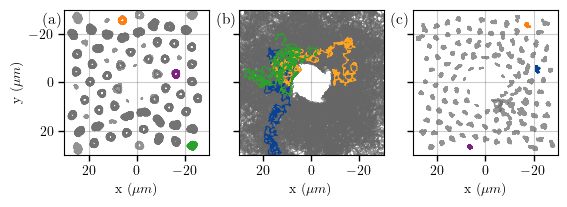

1Hz_seed123456_path1785: 600591 data points
  Frequency: 1Hz
  Seed: 123456
  Path: ./results/files_50M_specular
  Box size: (54.0, 54.0)
5Hz_seed123456_path1785: 600591 data points
  Frequency: 5Hz
  Seed: 123456
  Path: ./results/files_50M_specular
  Box size: (54.0, 54.0)
10Hz_seed123456_path1785: 600591 data points
  Frequency: 10Hz
  Seed: 123456
  Path: ./results/files_50M_specular
  Box size: (54.0, 54.0)


In [31]:
# Plot all trajectories together
highlight_particles = [('1Hz_seed123456_path1785', 1.0), ('1Hz_seed123456_path1785', 8.0), ('1Hz_seed123456_path1785', 50.0), ('5Hz_seed123456_path1785', 1.0), ('5Hz_seed123456_path1785', 8.0), ('5Hz_seed123456_path1785', 50.0), ('10Hz_seed123456_path1785', 1.0), ('10Hz_seed123456_path1785', 8.0), ('10Hz_seed123456_path1785', 50.0)]
fig, ax = plot_multiple_trajectories(all_trajectories, particle_type=1, highlight_particles=highlight_particles)
plt.show()
    
    # Access individual simulation data
for sim_name, sim_data in all_trajectories.items():
    print(f"{sim_name}: {len(sim_data['data'])} data points")
    print(f"  Frequency: {sim_data['freq']}Hz")
    print(f"  Seed: {sim_data['seed']}")
    print(f"  Path: {sim_data['path']}")
    print(f"  Box size: {sim_data['box_size']}")

# Utility function to check what's in cache
def list_cached_files():
    """List all cached trajectory files"""
    cache_files = list(CACHE_DIR.glob("*.pkl"))
    print(f"Found {len(cache_files)} cached files:")
    for f in cache_files:
        print(f"  {f.name}")

# Angular velocity vs time

In [14]:
def parse_frame(frame):
    return pd.DataFrame(frame[:,1:], columns = ["type","x","y"], 
                 index = pd.Index(frame[:,0], name = "id"))

def calc_ang_vel(series):
    series[:] = np.unwrap(series)
    return series.diff()
    
def angular_velocity(freq, seed, dir):
    trj = sp.read_timesteps(os.path.join(dir,f"mag_ratchet_{freq}Hz_{seed}.lammpstrj"))
    trj = pd.concat([parse_frame(trj[k]) for k in trj.keys()],
          keys = trj.keys(), names = ["frame"])
    trh = trj.query("type==2")
    cm = trh.filter(["x","y"]).groupby("frame").mean()
    trj_shift = cm - trj.query("type==2")
    trj_shift = trj_shift.eval("r = sqrt(x**2+y**2)")
    trj_shift["theta"] = np.arctan2(trj_shift["y"], trj_shift["x"])
    trj_shift["theta"] = trj_shift["theta"].where(trj_shift["theta"] >= 0, trj_shift["theta"] + 2 * np.pi)
    
    dt = 1e-2
    trj_shift["v_th"] = trj_shift.groupby("id", group_keys=False).theta.apply(calc_ang_vel).rename("v_th")/dt
    trj_shift = trj_shift.query("frame >= 2500000")

    # Return the actual time series data instead of just statistics
    time_series = trj_shift.groupby("frame").mean().v_th
    return time_series

def analyze_frequency_data(frequencies, seeds_range, data_dir):
    """
    Analyze data for multiple frequencies and seeds, returning time series for plotting
    """
    all_time_series = {}
    
    for freq in frequencies:
        freq_data = []
        for seed in seeds_range:
            try:
                time_series = angular_velocity(freq, seed, data_dir)
                freq_data.append({
                    'seed': seed,
                    'time_series': time_series
                })
                print(f"Processed frequency {freq}Hz, seed {seed}")
            except Exception as e:
                print(f"Error processing frequency {freq}Hz, seed {seed}: {e}")
                continue
        
        if freq_data:
            all_time_series[freq] = freq_data
    
    return all_time_series

def calculate_rolling_mean(time_series_data, window_size=1000):
    """
    Calculate rolling mean for each frequency across all seeds
    
    Parameters:
    - time_series_data: output from analyze_frequency_data
    - window_size: size of the rolling window
    
    Returns:
    - Dictionary with frequencies as keys and rolling mean series as values
    """
    rolling_means = {}
    
    for freq, freq_data in time_series_data.items():
        # Combine all seeds for this frequency
        all_seeds_data = []
        for data in freq_data:
            all_seeds_data.append(data['time_series'])
        
        # Create a DataFrame with all seeds as columns
        df = pd.concat(all_seeds_data, axis=1)
        df.columns = [f'seed_{data["seed"]}' for data in freq_data]
        
        # Calculate mean across seeds for each frame
        mean_series = df.mean(axis=1)
        
        # Calculate rolling mean
        rolling_mean = mean_series.rolling(window=window_size, center=True).mean()
        rolling_means[freq] = rolling_mean
    
    return rolling_means

def plot_simulations_with_rolling_mean(time_series_data, frequencies_to_plot=None, seeds_to_plot=None, window_size=1000):
    """
    Plot individual simulations and their frequency rolling means
    
    Parameters:
    - time_series_data: output from analyze_frequency_data
    - frequencies_to_plot: list of frequencies to plot (if None, plot all)
    - seeds_to_plot: list of seeds to plot (if None, plot all)
    - window_size: size of the rolling window for mean calculation
    """

    plt.rcParams.update({
        "text.usetex": True,          # Use LaTeX to render all text
        "font.family": "serif",       # Use serif font (like LaTeX)
        "font.serif": ["Computer Modern"],  # Use Computer Modern (LaTeX default)
        "font.size": 11,              # Match your document font size
    })

    #plt.style.use('default')  # Reset to default for full control

    # Create figure with exact width for LaTeX (460pt = 460/72 = ~6.39 inches)
    fig_width_pt = 460
    inches_per_pt = 1/72.27
    fig_width = fig_width_pt * inches_per_pt
    # Golden ratio for height
    golden_ratio = (5**0.5 - 1)/2
    fig_height = fig_width * golden_ratio
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height))
    
    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    
    # Calculate rolling means
    rolling_means = calculate_rolling_mean(time_series_data, window_size)
    
    # Plot 1: Individual simulations
    for freq in frequencies:
        if freq not in time_series_data:
            continue
            
        freq_data = time_series_data[freq]
        seeds = seeds_to_plot if seeds_to_plot else [data['seed'] for data in freq_data]
        
        for data in freq_data:
            if data['seed'] in seeds:
                time_series = data['time_series']
                ax1.plot(time_series.index, time_series.values, 
                        label=f'{freq}Hz, seed {data["seed"]}', alpha=0.3, linewidth=0.5)
    
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Angular Velocity')
    ax1.set_title('Individual Simulations - Angular Velocity vs Time')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Rolling means for each frequency
    for freq in frequencies:
        if freq in rolling_means:
            rolling_mean = rolling_means[freq]
            ax2.plot(rolling_mean.index, rolling_mean.values, 
                    label=f'{freq}Hz', linewidth=2)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (rad/s)')
    ax2.set_title(f'Rolling Mean (window={window_size}) - Angular Velocity vs Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()

    plt.savefig("./figures/time_series.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/time_series.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/time_series.png", format="png", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/time_series.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/time_series.pdf", format="pdf", bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return rolling_means

def plot_rolling_means_only(time_series_data, frequencies_to_plot=None, window_size=1000):
    """
    Plot only the rolling means for each frequency in the same plot
    
    Parameters:
    - time_series_data: output from analyze_frequency_data
    - frequencies_to_plot: list of frequencies to plot (if None, plot all)
    - window_size: size of the rolling window for mean calculation
    """
    #plt.style.use('default')  # Reset to default for full control
    plt.rcParams.update({
        "text.usetex": True,          # Use LaTeX to render all text
        "font.family": "serif",       # Use serif font (like LaTeX)
        "font.serif": ["Computer Modern"],  # Use Computer Modern (LaTeX default)
        "font.size": 11,              # Match your document font size
    })

    # Create figure with exact width for LaTeX (460pt = 460/72 = ~6.39 inches)
    fig_width_pt = 460
    inches_per_pt = 1/72.27
    fig_width = fig_width_pt * inches_per_pt
    # Golden ratio for height
    golden_ratio = (5**0.5 - 1)/2
    fig_height = fig_width * golden_ratio

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
    
    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    
    # Calculate rolling means
    rolling_means = calculate_rolling_mean(time_series_data, window_size)
    
    # Plot rolling means for each frequency
    for freq in frequencies:
        if freq in rolling_means:
            rolling_mean = rolling_means[freq]
            plt.plot(rolling_mean.index, rolling_mean.values, 
                    label=f'{freq} Hz', linewidth=2)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Frequency (rad/s)')
    plt.title(f'Rolling Mean Angular Velocity (window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig("./figures/time_series.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/time_series.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/time_series.png", format="png", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/time_series.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/time_series.pdf", format="pdf", bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return rolling_means

# Alternative: Plot individual simulations and rolling means in the same plot
def plot_combined(time_series_data, frequencies_to_plot=None, seeds_to_plot=None, window_size=1000):
    """
    Plot individual simulations (transparent) and rolling means (solid) in the same plot
    """

    #plt.style.use('default')  # Reset to default for full control
    plt.rcParams.update({
        "text.usetex": True,          # Use LaTeX to render all text
        "font.family": "serif",       # Use serif font (like LaTeX)
        "font.serif": ["Computer Modern"],  # Use Computer Modern (LaTeX default)
        "font.size": 11,              # Match your document font size
    })

    # Create figure with exact width for LaTeX (460pt = 460/72 = ~6.39 inches)
    fig_width_pt = 460
    inches_per_pt = 1/72.27
    fig_width = fig_width_pt * inches_per_pt
    # Golden ratio for height
    golden_ratio = (5**0.5 - 1)/2
    fig_height = fig_width * golden_ratio

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
    
    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    
    # Calculate rolling means
    rolling_means = calculate_rolling_mean(time_series_data, window_size)
    
    # Define colors for each frequency
    colors = plt.cm.tab10(np.linspace(0, 1, len(frequencies)))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    color_dict = {freq: color for freq, color in zip(frequencies, colors)}
    
    # Plot individual simulations (transparent)
    for freq in frequencies:
        if freq not in time_series_data:
            continue
            
        freq_data = time_series_data[freq]
        seeds = seeds_to_plot if seeds_to_plot else [data['seed'] for data in freq_data]
        
        for data in freq_data:
            if data['seed'] in seeds:
                time_series = data['time_series']
                plt.plot(time_series.index*(10e-6), time_series.values, 
                        color=color_dict[freq], alpha=0.2, label=f'{freq} Hz', linewidth=0.5)
    
    # Plot rolling means (solid lines)
    for freq in frequencies:
        if freq in rolling_means:
            rolling_mean = rolling_means[freq]
            plt.plot(rolling_mean.index*(10e-6), rolling_mean.values, 
                    color=color_dict[freq], label=f'{freq} Hz mean', linewidth=2)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Frequency (rad/s)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.savefig("./figures/time_series.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/time_series.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/time_series.png", format="png", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/time_series.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/time_series.pdf", format="pdf", bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return rolling_means




# 2. Plot individual simulations and rolling means in separate subplots
#rolling_means = plot_simulations_with_rolling_mean(time_series_data, frequencies_to_plot=[, 2], window_size=1000)

# 3. Plot only the rolling means
#rolling_means = plot_rolling_means_only(time_series_data, frequencies_to_plot=[1, 2], window_size=1000)

# 4. Plot combined (individual + rolling means in same plot)
#rolling_means = plot_combined(time_series_data, frequencies_to_plot=[0, 5], window_size=1000)

In [15]:
data_dir = "./results/files_50M_specular/"
frequencies = [1, 5]
seeds_range = [123456]

# 1. Get the time series data
time_series_data = analyze_frequency_data(frequencies, seeds_range, data_dir)

Processed frequency 1Hz, seed 123456
Processed frequency 5Hz, seed 123456


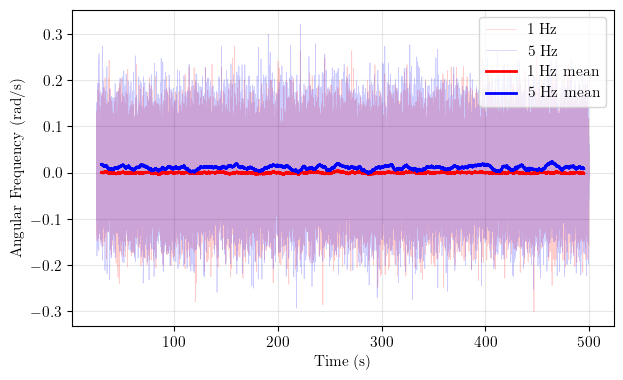

In [16]:
rolling_means = plot_combined(time_series_data, frequencies_to_plot=[1, 5], window_size=1000)

# Histogram

In [17]:
def plot_kde_angular_velocities(time_series_data, frequencies_to_plot=None):
    """
    Plot smooth KDE (Kernel Density Estimation) and histogram for better visualization of distributions
    """
    from scipy import stats
    plt.rcParams.update({
        "text.usetex": True,          # Use LaTeX to render all text
        "font.family": "serif",       # Use serif font (like LaTeX)
        "font.serif": ["Computer Modern"],  # Use Computer Modern (LaTeX default)
        "font.size": 11,              # Match your document font size
    })
    
     # Create figure with exact width for LaTeX (460pt = 460/72 = ~6.39 inches)
    fig_width_pt = 460
    inches_per_pt = 1/72.27
    fig_width = fig_width_pt * inches_per_pt
    # Golden ratio for height
    golden_ratio = (5**0.5 - 1)/2
    fig_height = fig_width * golden_ratio

    color = ['red', 'blue']

    # Create subplots: 1 row, 2 columns with shared y-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width * 1.6, fig_height), sharey=True)
    
    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    
    # Lists to store legend handles and labels
    legend_handles = []
    legend_labels = []
    
    for i, freq in enumerate(frequencies):
        if freq not in time_series_data:
            continue
            
        freq_angular_velocities = []
        for data in time_series_data[freq]:
            angular_velocities = data['time_series'].values
            freq_angular_velocities.extend(angular_velocities)
        
        # Convert to numpy array
        data_array = np.array(freq_angular_velocities)
        
        # Remove outliers for better visualization (optional)
        q1, q3 = np.percentile(data_array, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_data = data_array[(data_array >= lower_bound) & (data_array <= upper_bound)]
        
        # Create KDE
        kde = stats.gaussian_kde(filtered_data)
        x_range = np.linspace(filtered_data.min(), filtered_data.max(), 1000)
        kde_values = kde(x_range)
        
        # Plot histogram (normalized to match KDE scale)
        hist, bin_edges = np.histogram(filtered_data, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        # Plot on both subplots
        
        # Left subplot: normal scale
        line1, = ax1.plot(x_range, kde_values, linewidth=2, color=color[i])
        ax1.fill_between(x_range, kde_values, alpha=0.3, color=color[i])
        bars1 = ax1.bar(bin_centers, hist, alpha=0.5, width=bin_width, 
                        color=color[i], edgecolor='black', linewidth=0.5)
        
        # Mark mean on left subplot
        mean_val = np.mean(filtered_data)
        mean_line1 = ax1.axvline(mean_val, color=color[i], linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Right subplot: semilog scale
        ax2.plot(x_range, kde_values, linewidth=2, color=color[i])
        ax2.fill_between(x_range, kde_values, alpha=0.3, color=color[i])
        ax2.bar(bin_centers, hist, alpha=0.5, width=bin_width, 
                color=color[i], edgecolor='black', linewidth=0.5)
        
        # Mark mean on right subplot
        ax2.axvline(mean_val, color=color[i], linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Store handles and labels for legend (only once per frequency)
        legend_handles.append((line1, bars1, mean_line1))
        legend_labels.append(f'{freq} Hz')
    
    # Configure left subplot (normal scale)
    ax1.set_xlabel('Angular Velocity (rad/s)')
    ax1.set_ylabel('Probability Density')
    ax1.grid(True, alpha=0.3)
    ax1.text(-0.12, 1.02, '(a)', transform=ax1.transAxes, fontsize=13, 
             fontweight='bold', va='top', ha='left')
    
    # Configure right subplot (semilog scale)
    ax2.set_xscale('log')
    ax2.set_xlabel('Angular Velocity (rad/s)')
    ax2.grid(True, alpha=0.3)
    ax2.text(-0.12, 1.02, '(b)', transform=ax2.transAxes, fontsize=13, 
             fontweight='bold', va='top', ha='left')
    
    # Create a single shared legend for the entire figure
    # Create custom legend entries that combine KDE line, histogram bars, and mean line
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Create simplified legend entries (just the color and frequency)
    simplified_handles = [Line2D([0], [0], color=color[i], linewidth=3, 
                                marker='s', markersize=8) 
                         for i in range(len(frequencies))]
    
    # Place the legend at the top center of the figure
    fig.legend(simplified_handles, legend_labels,
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.02),  # Adjust vertical position as needed
               ncol=len(frequencies),  # Number of columns in legend
               fontsize=11,
               frameon=True,
               fancybox=True,
               shadow=False)
    
    plt.tight_layout()
    
    # Adjust subplot parameters to make space for the shared legend
    plt.subplots_adjust(left=0.08, right=0.95, top=0.88, wspace=0.3)  # Reduced top margin for legend
    
    plt.savefig("./figures/histogram_comparison.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/histogram_comparison.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/histogram_comparison.png", format="png", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/histogram_comparison.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/histogram_comparison.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.show()

In [18]:
def plot_kde_angular_velocities(time_series_data, frequencies_to_plot=None):
    """
    Plot smooth KDE (Kernel Density Estimation) and histogram for better visualization of distributions
    """
    from scipy import stats
    plt.rcParams.update({
        "text.usetex": True,          # Use LaTeX to render all text
        "font.family": "serif",       # Use serif font (like LaTeX)
        "font.serif": ["Computer Modern"],  # Use Computer Modern (LaTeX default)
        "font.size": 11,              # Match your document font size
    })
    
     # Create figure with exact width for LaTeX (460pt = 460/72 = ~6.39 inches)
    fig_width_pt = 460
    inches_per_pt = 1/72.27
    fig_width = fig_width_pt * inches_per_pt
    # Golden ratio for height
    golden_ratio = (5**0.5 - 1)/2
    fig_height = fig_width * golden_ratio

    color = ['red', 'blue']

    # Create subplots: 1 row, 2 columns with shared x-axis instead of y-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width * 1.6, fig_height), sharex=True)
    
    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    
    # Lists to store legend handles and labels
    legend_handles = []
    legend_labels = []
    
    for i, freq in enumerate(frequencies):
        if freq not in time_series_data:
            continue
            
        freq_angular_velocities = []
        for data in time_series_data[freq]:
            angular_velocities = data['time_series'].values
            freq_angular_velocities.extend(angular_velocities)
        
        # Convert to numpy array
        data_array = np.array(freq_angular_velocities)
        
        # Remove outliers for better visualization (optional)
        q1, q3 = np.percentile(data_array, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_data = data_array[(data_array >= lower_bound) & (data_array <= upper_bound)]
        
        # Create KDE
        kde = stats.gaussian_kde(filtered_data)
        x_range = np.linspace(filtered_data.min(), filtered_data.max(), 1000)
        kde_values = kde(x_range)
        
        # Plot histogram (normalized to match KDE scale)
        hist, bin_edges = np.histogram(filtered_data, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        # Plot on both subplots
        
        # Left subplot: normal scale
        line1, = ax1.plot(x_range, kde_values, linewidth=2, color=color[i])
        ax1.fill_between(x_range, kde_values, alpha=0.3, color=color[i])
        # Replace bars with dots at middle top
        dots1 = ax1.scatter(bin_centers, hist, color=color[i], s=30, zorder=5)  # s controls dot size
        
        # Mark mean on left subplot
        mean_val = np.mean(filtered_data)
        mean_line1 = ax1.axvline(mean_val, color=color[i], linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Right subplot: semilog scale on Y-axis
        line2, = ax2.plot(x_range, kde_values, linewidth=2, color=color[i])
        ax2.fill_between(x_range, kde_values, alpha=0.3, color=color[i])
        # Replace bars with dots at middle top
        dots2 = ax2.scatter(bin_centers, hist, color=color[i], s=30, zorder=5)  # s controls dot size
        
        # Mark mean on right subplot
        ax2.axvline(mean_val, color=color[i], linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Store handles and labels for legend (only once per frequency)
        legend_handles.append((line1, dots1, mean_line1))
        legend_labels.append(f'{freq} Hz')
    
    # Configure left subplot (normal scale)
    ax1.set_xlabel('Angular Frequency (rad/s)')
    ax1.set_ylabel('Probability Density')
    ax1.grid(True, alpha=0.3)
    ax1.text(-0.12, 1.02, '(a)', transform=ax1.transAxes, fontsize=13, 
             fontweight='bold', va='top', ha='left')
    
    # Configure right subplot (semilog scale on Y-axis)
    ax2.set_yscale('log')  # Changed from set_xscale to set_yscale
    ax2.set_xlabel('Angular Frequency (rad/s)')
    ax2.set_ylabel('Probability Density')  # Keep the y-axis label
    ax2.grid(True, alpha=0.3)
    ax2.text(-0.12, 1.02, '(b)', transform=ax2.transAxes, fontsize=13, 
             fontweight='bold', va='top', ha='left')
    
    # Create a single shared legend for the entire figure
    from matplotlib.lines import Line2D
    
    # Create simplified legend entries (just the color and frequency)
    simplified_handles = [Line2D([0], [0], color=color[i], linewidth=3, 
                                marker='s', markersize=8) 
                         for i in range(len(frequencies))]
    
    # Place the legend at the top center of the figure
    fig.legend(simplified_handles, legend_labels,
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.02),
               ncol=len(frequencies),
               fontsize=11,
               frameon=True,
               fancybox=True,
               shadow=False)
    
    plt.tight_layout()
    
    # Adjust subplot parameters to make space for the shared legend
    plt.subplots_adjust(left=0.08, right=0.95, top=0.88, wspace=0.3)
    
    plt.savefig("./figures/histogram_comparison.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/histogram_comparison.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/histogram_comparison.png", format="png", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/histogram_comparison.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/histogram_comparison.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.show()

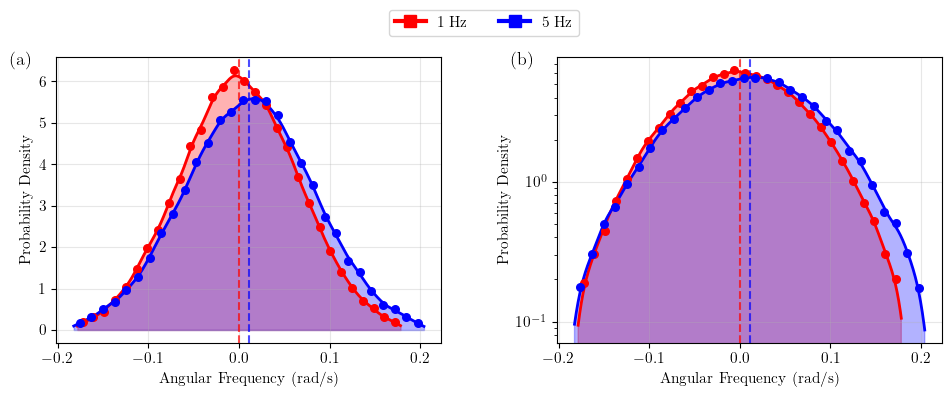

In [19]:
plot_kde_angular_velocities(time_series_data, frequencies_to_plot=[1, 5])

# Angular position vs time

# Debugging

In [20]:
def debug_angular_calculation(freq, seed, dir, num_frames=5):
    """
    Debug the angular position calculation step by step
    """
    trj = sp.read_timesteps(os.path.join(dir,f"mag_ratchet_{freq}Hz_{seed}.lammpstrj"))
    trj = pd.concat([parse_frame(trj[k]) for k in trj.keys()],
          keys = trj.keys(), names = ["frame"])
    
    # Focus on type 2 particles
    trh = trj.query("type==2")
    print(f"Number of type 2 particles: {len(trh.query('frame==0'))}")
    
    # Calculate center of mass
    cm = trh.filter(["x","y"]).groupby("frame").mean()
    print(f"\nCenter of mass coordinates (first {num_frames} frames):")
    print(cm.head(num_frames))
    
    # Calculate positions relative to center of mass
    trj_shift = cm - trj.query("type==2")
    trj_shift = trj_shift.eval("r = sqrt(x**2+y**2)")
    trj_shift["theta"] = np.arctan2(trj_shift["y"], trj_shift["x"])
    
    print(f"\nAngular positions for first particle (first {num_frames} frames):")
    first_particle = trj_shift.groupby("id").get_group(trj_shift.index.get_level_values('id')[1])
    print(first_particle.head(num_frames)[["x", "y", "theta"]])
    
    return trj_shift

# Usage:
debug_data = debug_angular_calculation(0, 123456, data_dir)

Number of type 2 particles: 471

Center of mass coordinates (first 5 frames):
              x         y
frame                    
0     -0.192144  0.096603
1000  -0.197690  0.104948
2000  -0.201045  0.103152
3000  -0.198259  0.104784
4000  -0.197534  0.098908

Angular positions for first particle (first 5 frames):
                    x         y     theta
frame id                                 
0     185.0  5.307856  4.596603  0.713710
1000  185.0  5.314200  4.606108  0.714141
2000  185.0  5.300525  4.592362  0.713937
3000  185.0  5.310711  4.591524  0.712897
4000  185.0  5.308096  4.598418  0.713883


In [21]:
def single_particle_angular_position(freq, seed, dir, particle_id=0):
    """
    Track angular position of a single specific particle relative to center of mass
    """
    trj = sp.read_timesteps(os.path.join(dir,f"mag_ratchet_{freq}Hz_{seed}.lammpstrj"))
    trj = pd.concat([parse_frame(trj[k]) for k in trj.keys()],
          keys = trj.keys(), names = ["frame"])
    
    trh = trj.query("type==2")
    cm = trh.filter(["x","y"]).groupby("frame").mean()
    
    # Get the specific particle's trajectory
    particle_data = trh.groupby("id").get_group(particle_id)
    
    # Calculate position relative to center of mass for this particle
    particle_relative_x = particle_data["x"] - cm["x"]
    particle_relative_y = particle_data["y"] - cm["y"]
    
    # Calculate angular position
    theta = np.arctan2(particle_relative_y, particle_relative_x)
    
    # Create time series
    time_series = pd.Series(theta.values, index=particle_data.index.get_level_values('frame'))
    time_series = time_series.sort_index()
    
    # Filter frames
    time_series = time_series[time_series.index >= 2500000]
    
    return time_series

def analyze_single_particle_data(frequencies, seeds_range, data_dir, particle_id=0):
    """
    Analyze single particle data for multiple frequencies and seeds
    """
    all_time_series = {}
    
    for freq in frequencies:
        freq_data = []
        for seed in seeds_range:
            try:
                time_series = single_particle_angular_position(freq, seed, data_dir, particle_id)
                freq_data.append({
                    'seed': seed,
                    'time_series': time_series,
                    'particle_id': particle_id
                })
                print(f"Processed frequency {freq}Hz, seed {seed}, particle {particle_id}")
            except Exception as e:
                print(f"Error processing frequency {freq}Hz, seed {seed}: {e}")
                continue
        
        if freq_data:
            all_time_series[freq] = freq_data
    
    return all_time_series

In [22]:
def plot_single_particle_displacement(time_series_data, frequencies_to_plot=None, seeds_to_plot=None):
    """
    Plot angular displacement of a single particle from its initial position
    """
    
    plt.figure(figsize=(12, 8))
    
    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    
    for freq in frequencies:
        if freq not in time_series_data:
            continue
            
        freq_data = time_series_data[freq]
        seeds = seeds_to_plot if seeds_to_plot else [data['seed'] for data in freq_data]
        
        for data in freq_data:
            if data['seed'] in seeds:
                time_series = data['time_series']
                particle_id = data['particle_id']
                
                # Calculate displacement from initial position
                initial_theta = time_series.iloc[0]
                displacement = time_series - initial_theta
                
                plt.plot(time_series.index, displacement, 
                        label=f'{freq}Hz, seed {data["seed"]}, particle {particle_id}', 
                        alpha=0.7, linewidth=1.5)
    
    plt.xlabel('Frame')
    plt.ylabel('Angular Displacement (radians)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [24]:
# Usage:
single_particle_data = analyze_single_particle_data([1, 5], [123456], data_dir, particle_id=147)


Processed frequency 1Hz, seed 123456, particle 147
Processed frequency 5Hz, seed 123456, particle 147


In [27]:
def plot_single_particle_displacement(time_series_data, frequencies_to_plot=None, seeds_to_plot=None):
    """
    Plot angular displacement of a single particle from its initial position - Publication quality
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Set style for publication-quality plots
    plt.rcParams.update({
        "text.usetex": True,          # Use LaTeX to render all text
        "font.family": "serif",       # Use serif font (like LaTeX)
        "font.serif": ["Computer Modern"],  # Use Computer Modern (LaTeX default)
        "font.size": 11,              # Match your document font size
    })    
    # Create figure with exact width for LaTeX
    fig_width_pt = 460
    inches_per_pt = 1/72.27
    fig_width = fig_width_pt * inches_per_pt
    golden_ratio = (5**0.5 - 1)/2
    fig_height = fig_width * golden_ratio

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
    
    # Professional color palette and line styles
    colors = ['red', 'blue']
    line_styles = ['-', '--', '-.', ':']
    marker_styles = ['', 'o', 's', '^', 'D']  # Empty string for no markers
    
    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    
    # Track legend items to avoid duplicates
    legend_handles = []
    legend_labels = []
    
    for freq_idx, freq in enumerate(frequencies):
        if freq not in time_series_data:
            continue
            
        freq_data = time_series_data[freq]
        seeds = seeds_to_plot if seeds_to_plot else [data['seed'] for data in freq_data]
        
        color = colors[freq_idx]
        
        for seed_idx, data in enumerate(freq_data):
            if data['seed'] in seeds:
                time_series = data['time_series']
                particle_id = data['particle_id']
                
                # Calculate displacement from initial position
                initial_theta = time_series.iloc[0]
                displacement = time_series - initial_theta
                
                line_style = line_styles[seed_idx % len(line_styles)]
                marker = marker_styles[particle_id % len(marker_styles)] if particle_id is not None else ''
                
                # Plot with professional styling
                line = ax.plot(time_series.index*(10e-6), displacement,
                             color=color,
                             linestyle=line_style,
                             marker=marker,
                             markersize=3 if marker else 0,
                             markevery=20,  # Show markers every 20 points to avoid clutter
                             linewidth=1.5,
                             alpha=0.8,
                             label=f'{freq} Hz')[0]
                
                # Store for legend (group by frequency and seed)
                current_label = f'{freq} Hz'
                if current_label not in legend_labels:
                    legend_handles.append(line)
                    legend_labels.append(current_label)
    
    # Publication-quality styling
    ax.set_xlabel('Time (s)', fontsize=11, fontweight='normal')
    ax.set_ylabel('Angular Displacement (rad)', fontsize=11, fontweight='normal')
    
    # Improve ticks
    ax.tick_params(axis='both', which='major', labelsize=10, direction='out', length=4, width=1)
    ax.tick_params(axis='both', which='minor', direction='out', length=2, width=1)
    
    # Clean up spines
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color('black')
    
    # Add light grid
    ax.grid(True, linestyle='-', alpha=0.2, color='black')
    
    # Professional legend
    legend = ax.legend(legend_handles, legend_labels,
                      fontsize=9,
                      frameon=True,
                      fancybox=False,
                      framealpha=0.9,
                      edgecolor='black',
                      facecolor='white',
                      loc='upper left',
                      )  # Outside on right side
    
    legend.get_frame().set_linewidth(0.5)
    
    # Adjust layout to accommodate external legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on right for legend
    
    # Save in multiple formats for publication
    plt.savefig("./figures/particle_displacement.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/particle_displacement.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/particle_displacement.png", format="png", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/particle_displacement.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/particle_displacement.svg", format="svg", bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return fig, ax


# Alternative version with subplots for different frequencies
def plot_single_particle_displacement_subplots(time_series_data, frequencies_to_plot=None):
    """
    Plot angular displacement in separate subplots for each frequency - Publication quality
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Set style
    #plt.style.use('default')
    # Enable LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,          # Use LaTeX to render all text
        "font.family": "serif",       # Use serif font (like LaTeX)
        "font.serif": ["Computer Modern"],  # Use Computer Modern (LaTeX default)
        "font.size": 11,              # Match your document font size
    })
    
    # Create figure with exact width for LaTeX
    fig_width_pt = 460
    inches_per_pt = 1/72.27
    fig_width = fig_width_pt * inches_per_pt
    golden_ratio = (5**0.5 - 1)/2
    fig_height = fig_width * golden_ratio * 1.2  # Slightly taller for subplots

    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    n_freqs = len(frequencies)
    
    # Create subplots (vertical arrangement)
    fig, axes = plt.subplots(n_freqs, 1, figsize=(fig_width, fig_height), sharex=True)
    if n_freqs == 1:
        axes = [axes]
    
    # Color palette for different seeds
    colors = plt.cm.Set1(np.linspace(0, 1, 8))
    
    for idx, (freq, ax) in enumerate(zip(frequencies, axes)):
        if freq not in time_series_data:
            continue
            
        freq_data = time_series_data[freq]
        
        for seed_idx, data in enumerate(freq_data):
            time_series = data['time_series']
            particle_id = data['particle_id']
            
            # Calculate displacement from initial position
            initial_theta = time_series.iloc[0]
            displacement = time_series - initial_theta
            
            # Plot with professional styling
            ax.plot(time_series.index, displacement,
                   color=colors[seed_idx % len(colors)],
                   linewidth=1.2,
                   alpha=0.8,
                   label=f'Seed {data["seed"]}')
        
        # Subplot styling
        ax.set_ylabel('Δθ (rad)', fontsize=10, fontweight='normal')
        ax.set_title(f'{freq} Hz', fontsize=11, fontweight='bold', pad=10)
        
        # Professional axis styling
        ax.tick_params(axis='both', which='major', labelsize=9, direction='out', length=3, width=1)
        for spine in ax.spines.values():
            spine.set_linewidth(0.8)
            spine.set_color('black')
        
        ax.grid(True, linestyle='-', alpha=0.2, color='black')
        
        # Legend for each subplot
        if len(freq_data) > 1:
            legend = ax.legend(fontsize=8,
                             frameon=True,
                             fancybox=False,
                             framealpha=0.9,
                             edgecolor='black',
                             facecolor='white',
                             loc='upper right')
            legend.get_frame().set_linewidth(0.5)
    
    # Common x-axis label
    axes[-1].set_xlabel('Frame', fontsize=11, fontweight='normal')
    
    plt.tight_layout(pad=2.0)
    
    # Save figures
    plt.savefig("./figures/particle_displacement_subplots.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/particle_displacement_subplots.pdf", format="pdf", bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return fig, axes


# Version for cumulative displacement (integrated effect)
def plot_cumulative_displacement(time_series_data, frequencies_to_plot=None):
    """
    Plot cumulative angular displacement showing net rotation - Publication quality
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.style.use('default')
    
    # Create figure with exact width for LaTeX
    fig_width_pt = 460
    inches_per_pt = 1/72.27
    fig_width = fig_width_pt * inches_per_pt
    golden_ratio = (5**0.5 - 1)/2
    fig_height = fig_width * golden_ratio

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
    
    colors = ["red", "blue"]
    line_styles = ['-', '--', '-.', ':']
    
    frequencies = frequencies_to_plot if frequencies_to_plot else list(time_series_data.keys())
    
    legend_handles = []
    legend_labels = []
    
    for freq_idx, freq in enumerate(frequencies):
        if freq not in time_series_data:
            continue
            
        freq_data = time_series_data[freq]
        color = colors[freq_idx]
        
        for seed_idx, data in enumerate(freq_data):
            time_series = data['time_series']
            
            # Calculate cumulative displacement (integrated effect)
            angular_velocity = time_series.diff().fillna(0)  # Approximate derivative
            cumulative_displacement = angular_velocity.cumsum()
            
            line_style = line_styles[seed_idx % len(line_styles)]
            
            line = ax.plot(time_series.index, cumulative_displacement,
                         color=color,
                         linestyle=line_style,
                         linewidth=1.5,
                         alpha=0.8,
                         label=f'{freq} Hz, seed {data["seed"]}')[0]
            
            # Store for legend
            if seed_idx == 0:  # One entry per frequency
                legend_handles.append(line)
                legend_labels.append(f'{freq} Hz')
    
    # Professional styling
    ax.set_xlabel('Frame', fontsize=11, fontweight='normal')
    ax.set_ylabel('Cumulative Angular Displacement (rad)', fontsize=11, fontweight='normal')
    
    ax.tick_params(axis='both', which='major', labelsize=10, direction='out', length=4, width=1)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color('black')
    
    ax.grid(True, linestyle='-', alpha=0.2, color='black')
    
    legend = ax.legend(legend_handles, legend_labels,
                      fontsize=9,
                      frameon=True,
                      fancybox=False,
                      framealpha=0.9,
                      edgecolor='black',
                      facecolor='white',
                      loc='upper left')
    legend.get_frame().set_linewidth(0.5)
    
    plt.tight_layout(pad=2.0)
    
    plt.savefig("./figures/cumulative_displacement.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("./figures/cumulative_displacement.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/cumulative_displacement.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.savefig("../../thesis/manuscript/figures/cumulative_displacement.svg", format="svg", bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return fig, ax

Processed frequency 1Hz, seed 654321, particle 170
Processed frequency 5Hz, seed 654321, particle 170


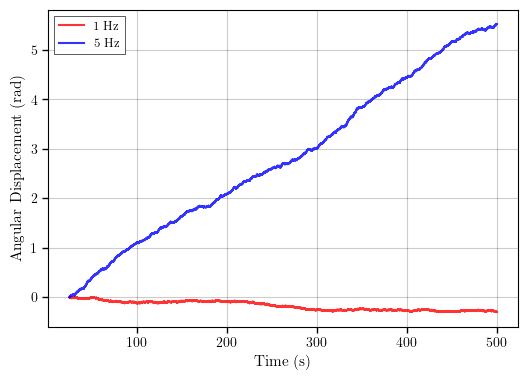

(<Figure size 636.502x393.38 with 1 Axes>,
 <Axes: xlabel='Time (s)', ylabel='Angular Displacement (rad)'>)

In [30]:
single_particle_data = analyze_single_particle_data([1, 5], [654321], data_dir, particle_id=170)
plot_single_particle_displacement(single_particle_data, frequencies_to_plot=[1, 5], seeds_to_plot=[654321])